In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from baryrat import aaa

%matplotlib inline

from src.helpers import plot_eigenvalues, get_FD_matrix
from src.experiments import (
    get_bound_chebyshev, get_bound_taylor,
    get_test_matrices, get_convergence_phi,
)
from src.solvers import Phi

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Properties of the test matrices

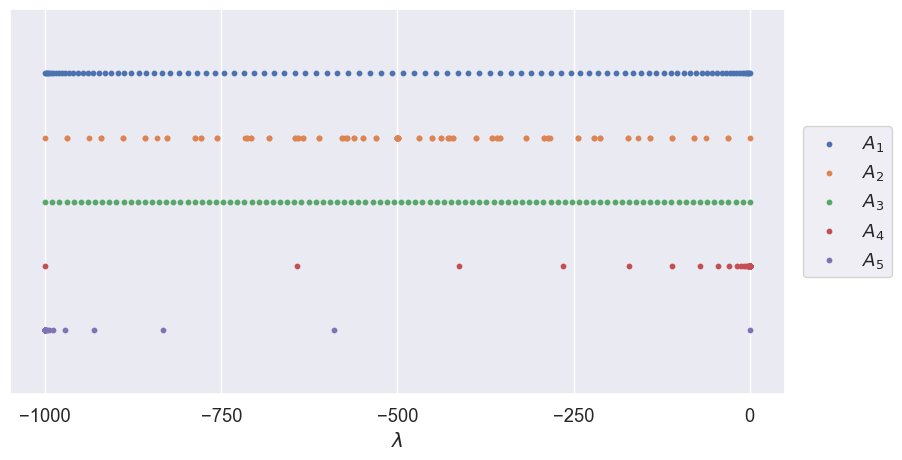

In [7]:
# Eigenvalues

plot_eigenvalues(
    As=[*get_test_matrices(n=100, interval=(-1000, 0))],
    legends=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$'],
    xticks=[-1000, -750, -500, -250, 0],
    # range_=(-1000, 0),
)

# Scalar $\varphi$-functions

## On the left complex half plane

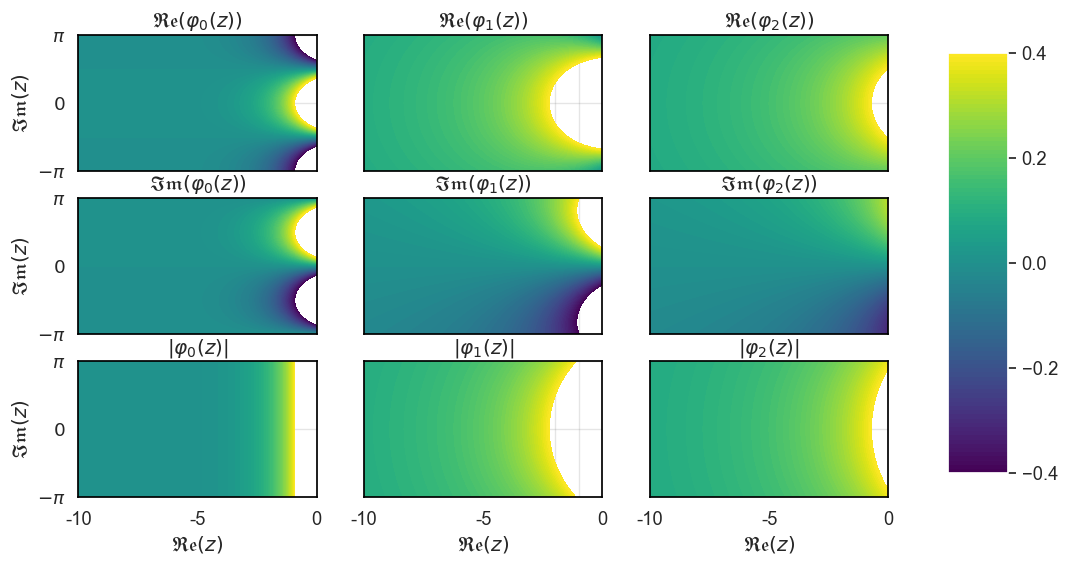

In [3]:
a = np.linspace(-10, 0, 101)
b = np.linspace(-np.pi, np.pi, 101)
a, b = np.meshgrid(a, b)
z = a + 1j * b

ps = [0, 1, 2]
cbarmarg = (-.4, +.4)
levels = np.linspace(cbarmarg[0], cbarmarg[1], 101)

fig, axs = plt.subplots(nrows=3, ncols=len(ps), figsize=(12, 6), sharey=True, sharex=True)
for idx, p in enumerate(ps):
    f = Phi(p=p)
    r = f.scalar(z)

    cmap = 'viridis'
    norm='linear'
    h0 = axs[0, idx].contourf(z.real, z.imag, r.real, levels=levels, cmap=cmap, norm=norm)
    h1 = axs[1, idx].contourf(z.real, z.imag, r.imag, levels=levels, cmap=cmap, norm=norm)
    h1 = axs[2, idx].contourf(z.real, z.imag, np.abs(r), levels=levels, cmap=cmap, norm=norm)
    axs[0, idx].set(title=f'$\\mathfrak{{Re}}(\\varphi_{f.p}(z))$')
    axs[1, idx].set(title=f'$\\mathfrak{{Im}}(\\varphi_{f.p}(z))$')
    axs[2, idx].set(title=f'$|\\varphi_{f.p}(z)|$')

for ax in axs[-1, :]:
    ax.set(xlabel='$\\mathfrak{Re}(z)$', xticks=[-10, -5, -4, -3, -2, -1, 0], xticklabels=[-10, -5, '', '', '', '', 0])
for ax in axs[:, 0]:
    ax.set(ylabel='$\\mathfrak{Im}(z)$', yticks=[-np.pi, 0, np.pi], yticklabels=['$-\pi$', '$0$', '$\pi$'])
for ax in axs.flat:
    ax.grid(color='gray', alpha=.2)
    ax.set(facecolor='white', axisbelow=True)
    for spine in ax.spines.values():
        spine.set_color('black')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(h0, cax=cbar_ax, ticks=[cbarmarg[0], (cbarmarg[0] / 2), 0, (cbarmarg[1] / 2), cbarmarg[1]])

## In proximity of zero

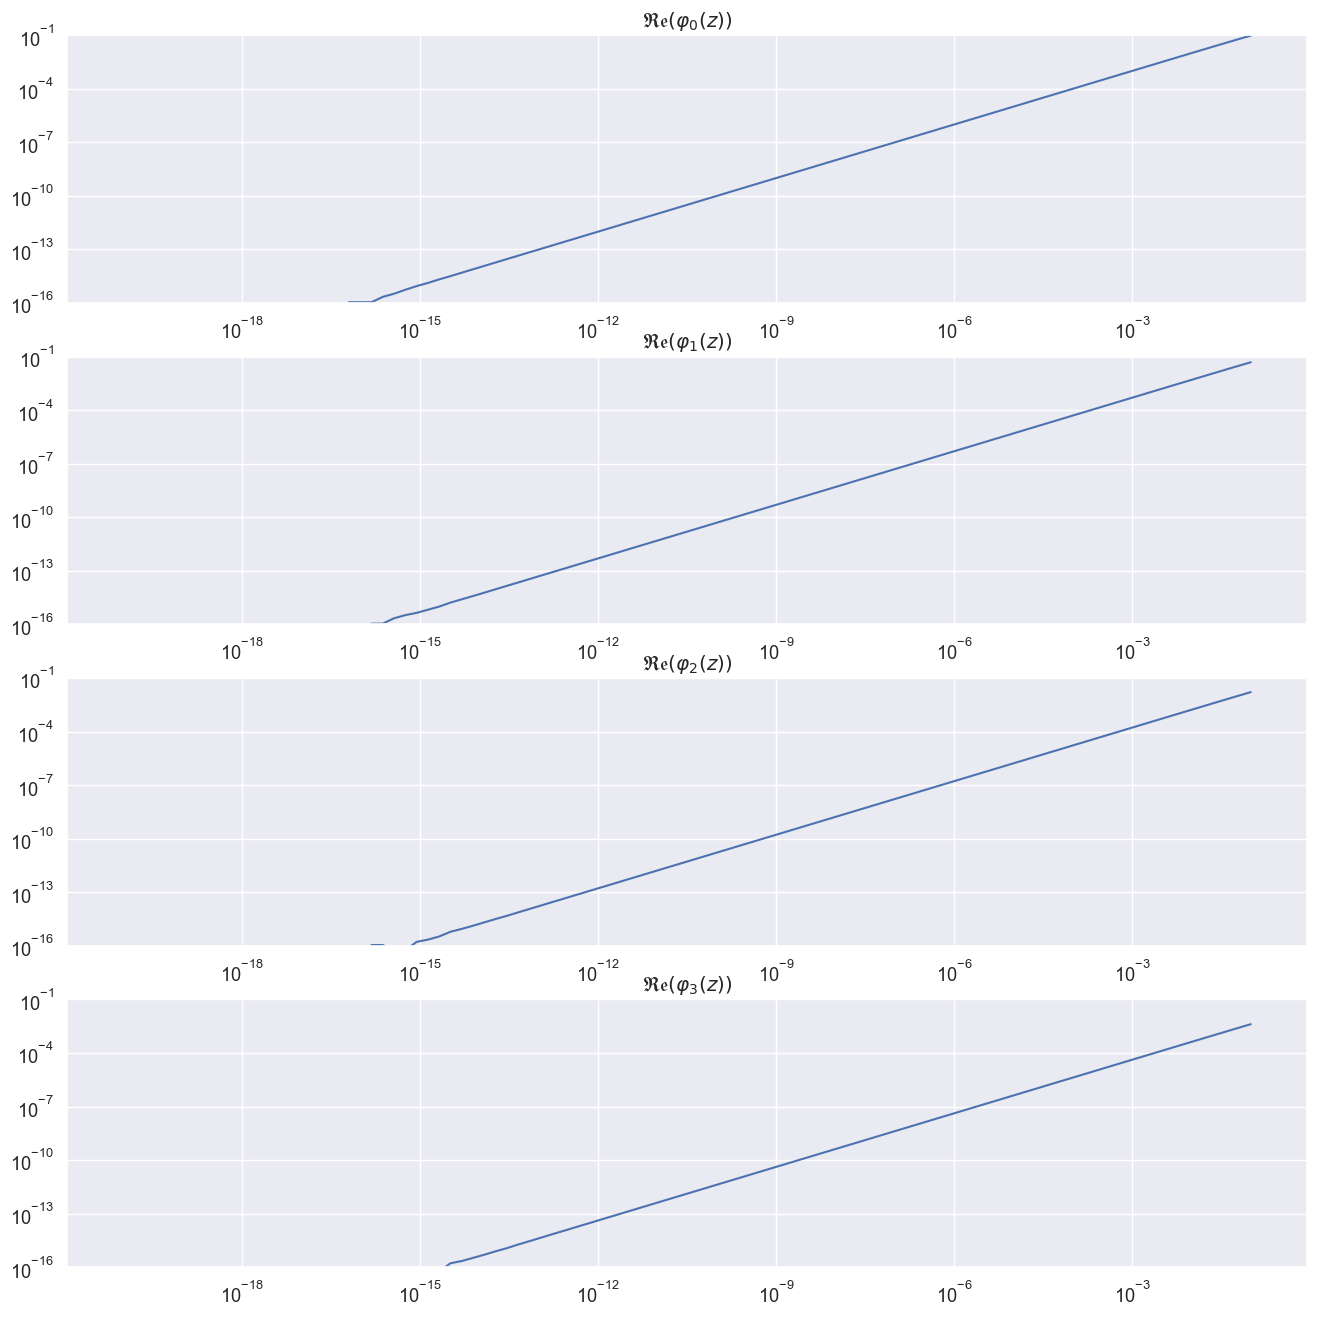

In [4]:
a = np.logspace(-1, -20, 101)
z = -a

ps = [0, 1, 2, 3]
eps = 1e-02
cbarmarg = (-eps, +eps)
levels = np.linspace(cbarmarg[0], cbarmarg[1], 101)

fig, axs = plt.subplots(ncols=1, nrows=len(ps), figsize=(16, 16), sharey=False, sharex=False)
for idx, p in enumerate(ps):
    f = Phi(p=p)
    r = np.abs(
        f.scalar(z)
        - 1 / np.math.factorial(f.p)
    )

    h0 = axs[idx].plot(a, r)
    axs[idx].set(title=f'$\\mathfrak{{Re}}(\\varphi_{f.p}(z))$')

for ax in axs.flat:
    ax.set(xscale='log', yscale='log', ylim=[1e-16, 1e-01])

# The AAA algorithm

## What happens to `m` poles when $a \to -\infty$?

In [69]:
m = 2

nodes = []
poles_real = []
poles_imag = []
errors = []
ps = []
as_ = []
# for a in tqdm([1e02, 1e03, 1e04, 1e05]):
for a in tqdm([1e04]):
    a = int(a)
    for p in [1, 3, 5]:
        f = Phi(p=p)
        Z = np.geomspace(-a, -1e-16, 30000)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        errors.append(e)
        ps.append(p)
        as_.append(a)

  0%|          | 0/1 [00:00<?, ?it/s]

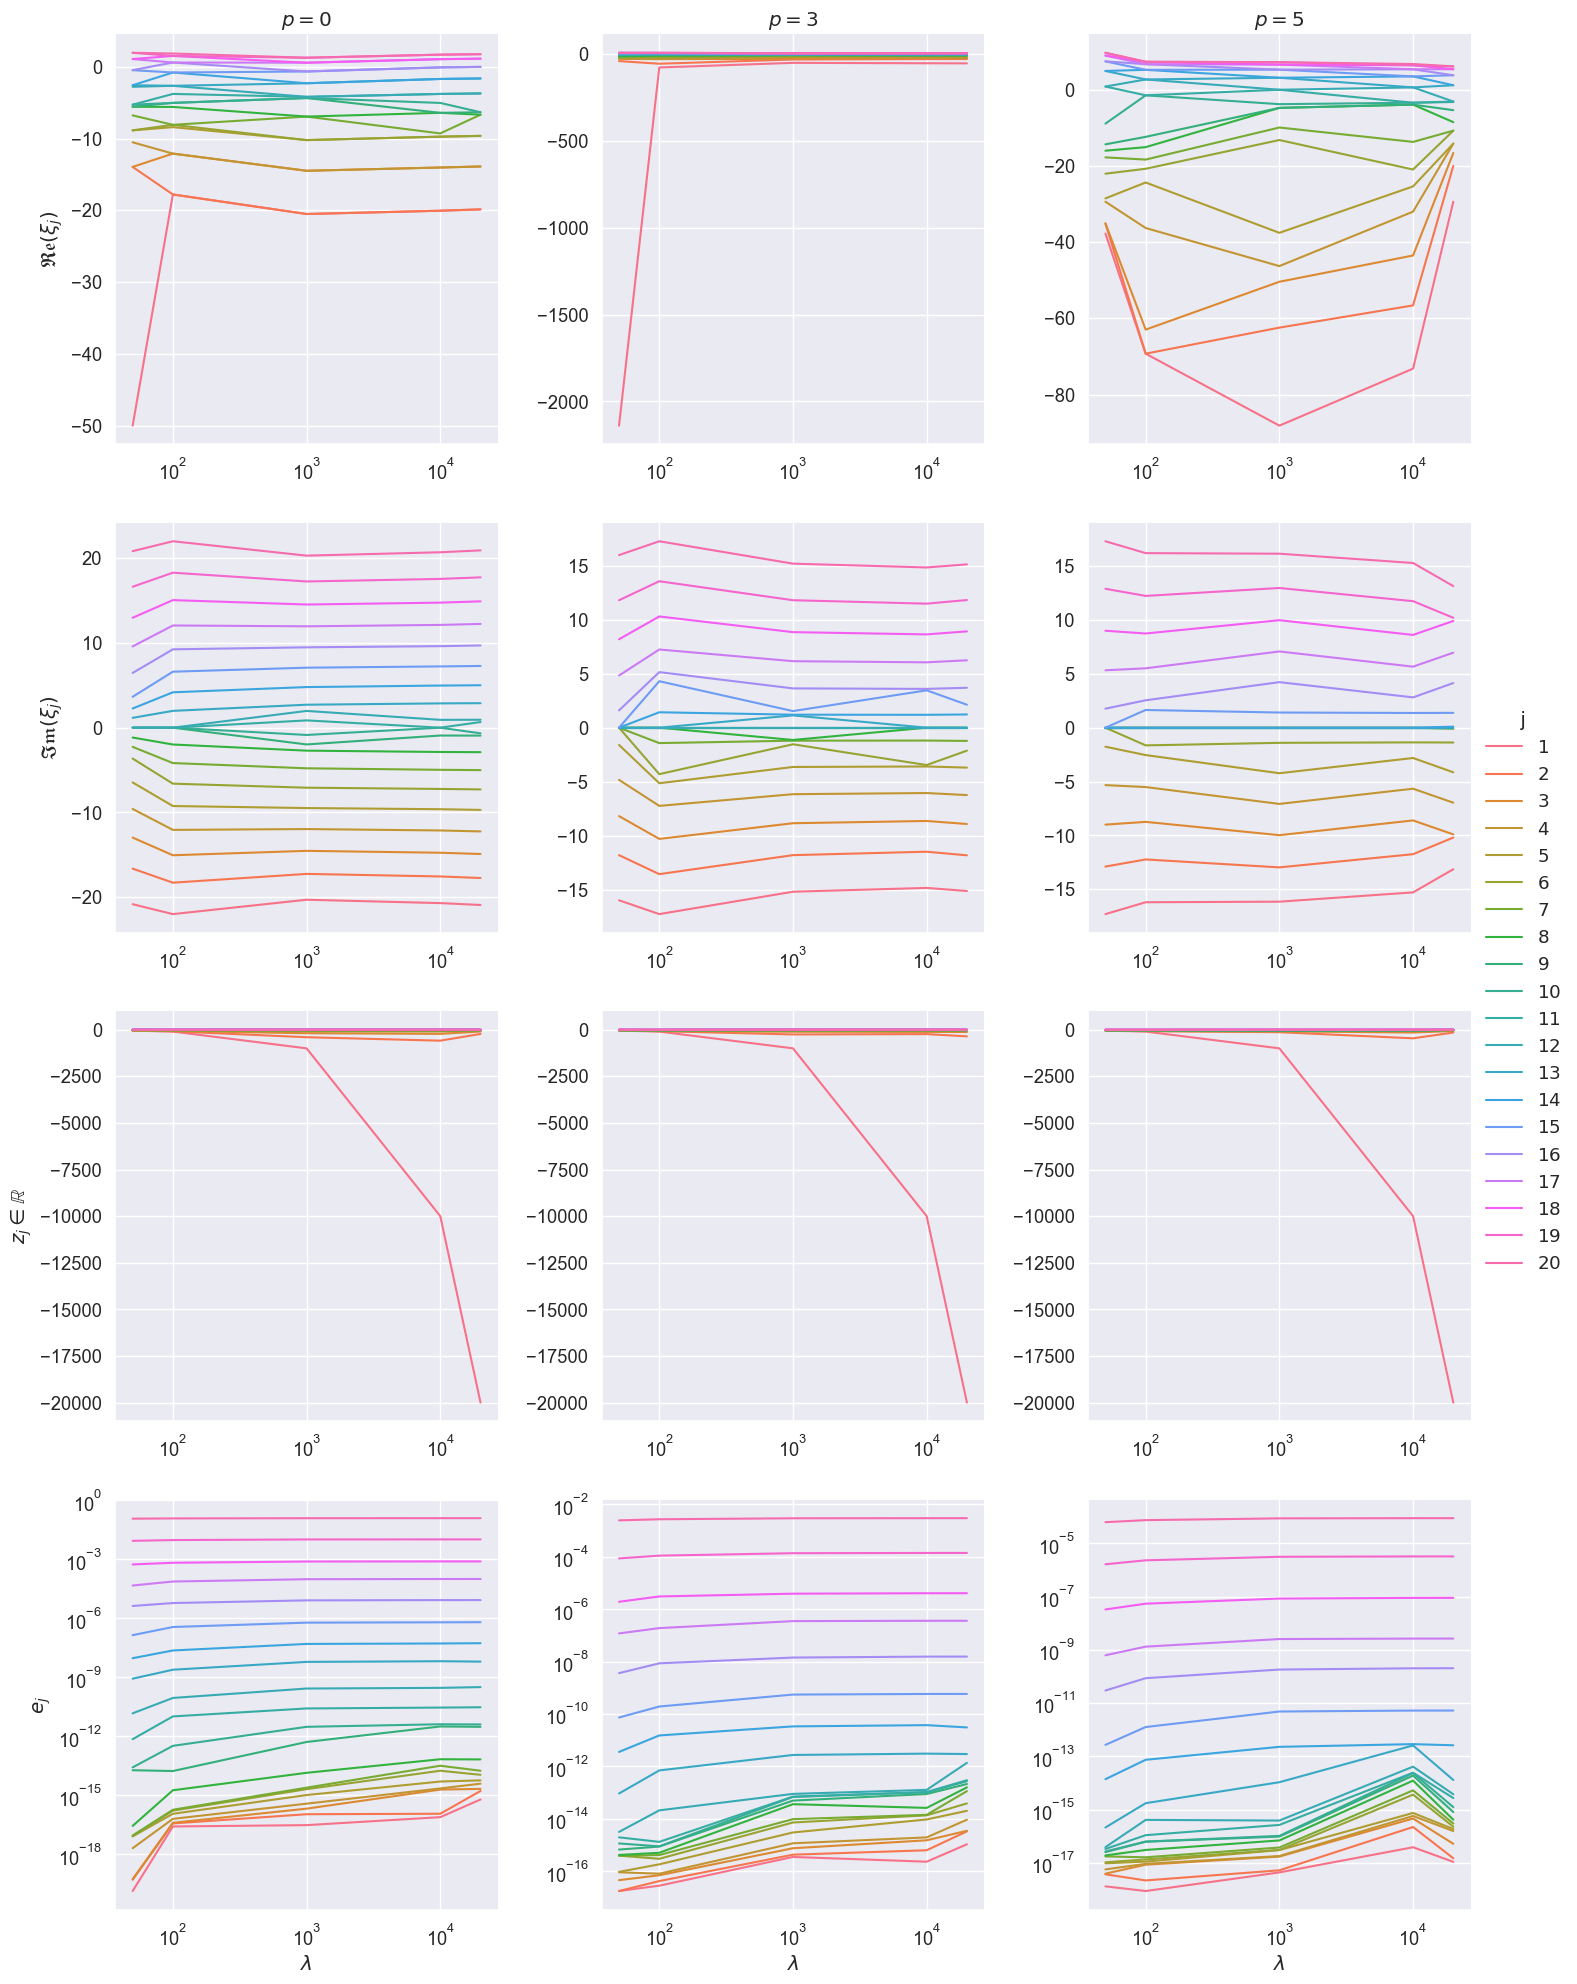

In [131]:
sort = True
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_j$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df_real = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
df_real['what'] = '$\\mathfrak{Re}(\\xi_j)$'
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df_imag = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
df_imag['what'] = '$\\mathfrak{Im}(\\xi_j)$'
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

errors_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in errors] for m in range(m)})
errors_['what'] = '$e_j$'
df_errors = pd.concat([data, errors_], axis=1)
df_errors = df_errors.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df = pd.concat([df_real, df_imag, df_nodes, df_errors])
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='j',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', ylabel='')

ps_ = list(set(ps))
for i, axs in enumerate(fg.axes):
    for j, ax in enumerate(axs):
        if i == 0:
            ax.set(title=f'$p = {ps_[j]}$')
        else:
            ax.set(title='')
        if i == 3:
            ax.set(yscale='log')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_j)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_j)$');
fg.axes[2, 0].set(ylabel='$z_j \\in \\mathbb{R}$');
fg.axes[3, 0].set(ylabel='$e_j$');

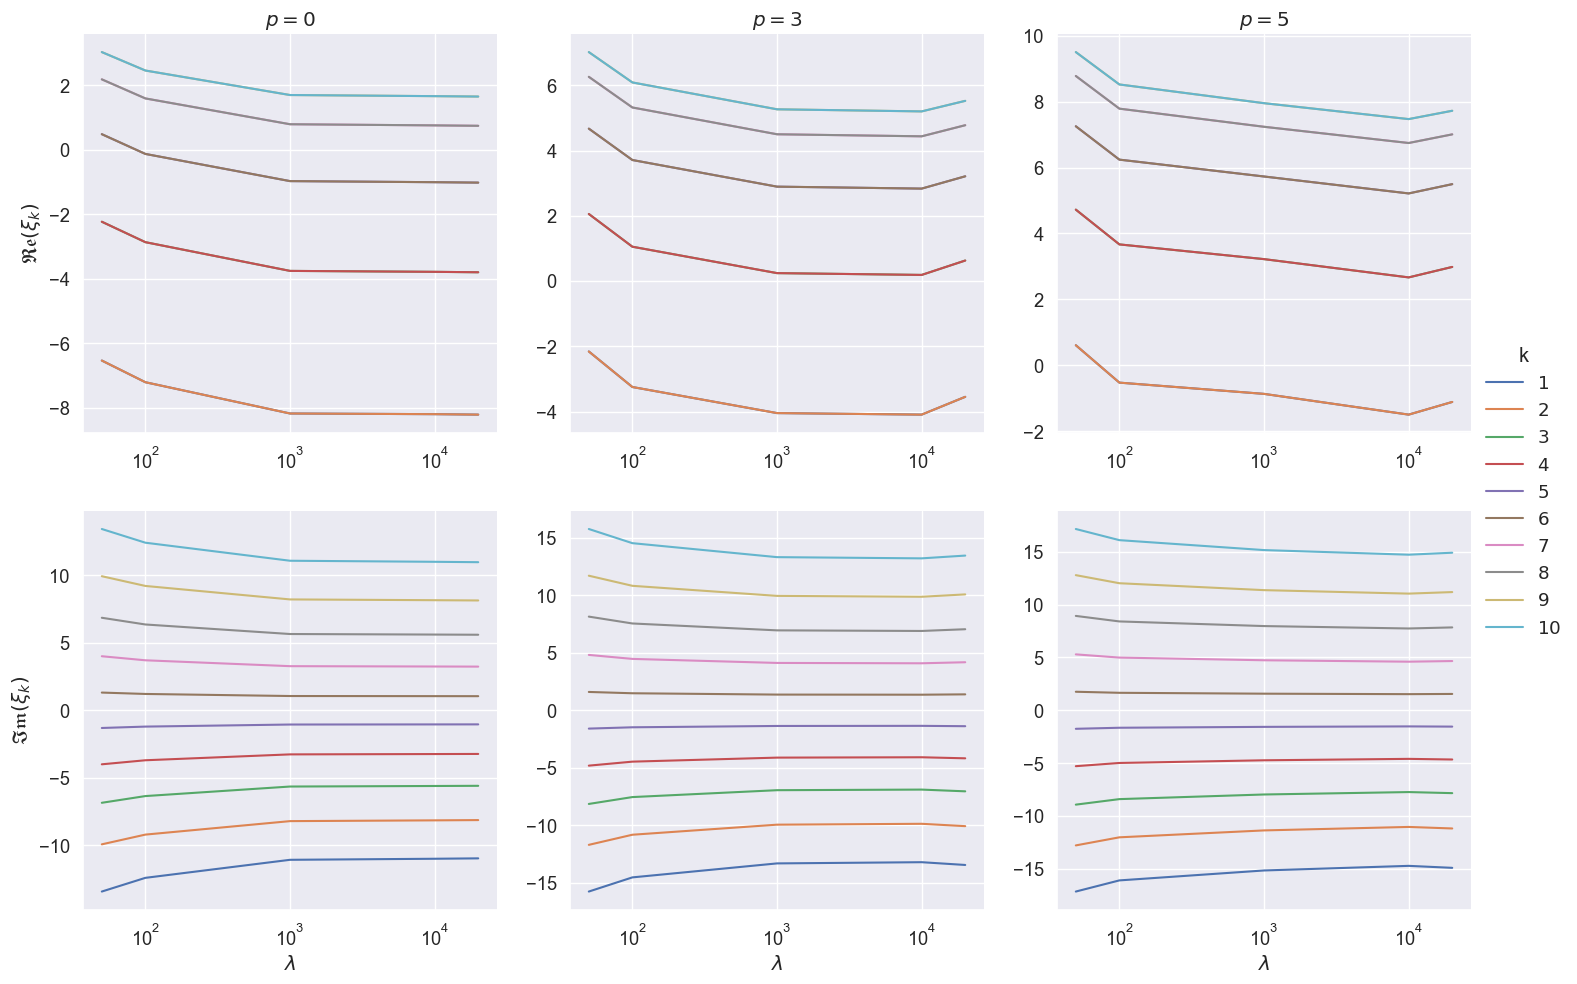

In [78]:
sort = True
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_k$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df_real = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
df_real['what'] = '$\\mathfrak{Re}(\\xi_k)$'
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df_imag = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
df_imag['what'] = '$\\mathfrak{Im}(\\xi_k)$'
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df = pd.concat([df_real, df_imag])
df['a'] = df['a'].abs()
# df = df[(df['p'] == 3)]
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='k',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', title='')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_k)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_k)$');
ps_ = [0, 3, 5]
for idx, ax in enumerate(fg.axes[0]):
    ax.set(title=f'$p={ps_[idx]}$');

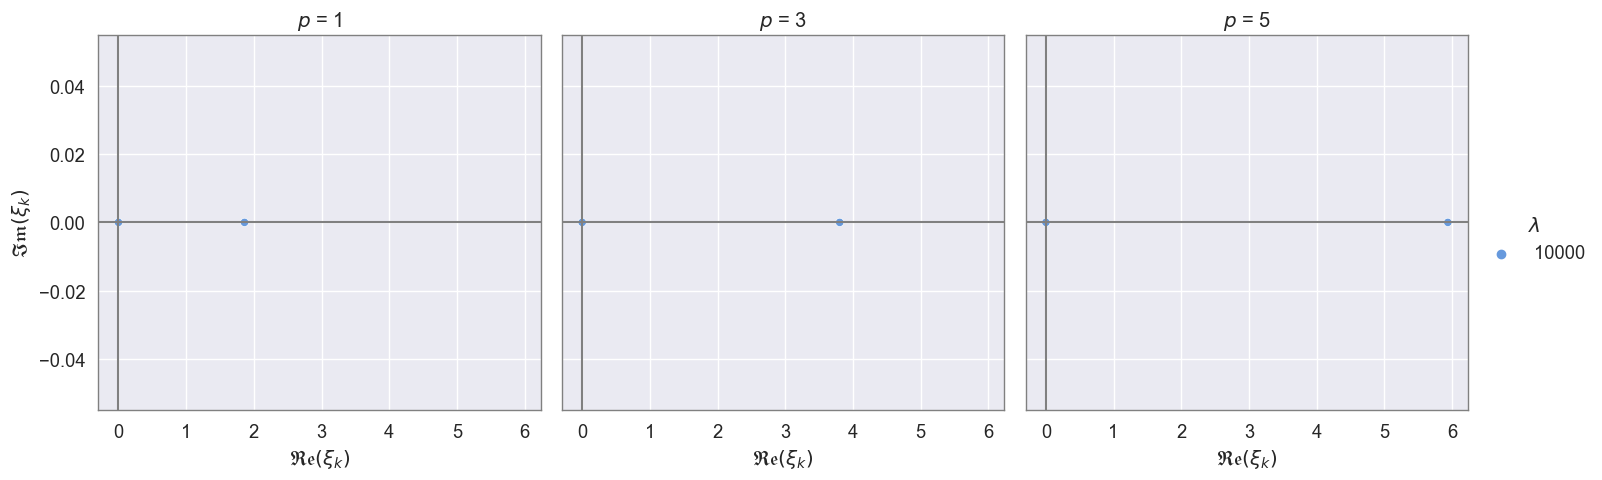

In [70]:
data = pd.DataFrame({'a': as_, 'p': ps})

df_real = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_real] for m in range(m)})
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p'), var_name='k', value_name='$\\mathfrak{Re}(\\xi_k)$')

df_imag = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_imag] for m in range(m)})
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p'), var_name='k', value_name='$\\mathfrak{Im}(\\xi_k)$')

df = df_real.merge(df_imag)
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\mathfrak{Re}(\\xi_k)$',
    y='$\\mathfrak{Im}(\\xi_k)$',
    hue='$\\lambda$',
    # style='k',
    col='$p$',
    kind='scatter',
    palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
    facet_kws={'sharex': True, 'sharey': True, 'despine': False},
)

for ax in fg.axes.flatten():
    ax.axhline(y=0, color='gray', linestyle='-')
    ax.axvline(x=0, color='gray', linestyle='-')
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

## What happens to the maximum error with different discretizations?

In [247]:
m = 20

ps = []
as_ = []
methods = []
errors = []
for p in tqdm([1, 3, 5]):
    f = Phi(p=p)
    approx = {}

    for n in [500, 1e03, 5e03, 1e04, 2e04]:
        n = int(n)
        Z = np.geomspace(-10000, -1e-16, int(n))
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        approx[f'geomspace($-10^{4}$, $-\\epsilon$, ${n}$)'] = {'r': r, 'e': e}

        for a in np.geomspace(1e02, 1e05, 3):
            Z_err = np.linspace(-a, 0, int(2 * a))

            for key, val in approx.items():
                ps.append(p)
                as_.append(a)
                errors.append(np.abs(f.scalar(Z_err) - val['r'](Z_err)).max())
                methods.append(key)


  0%|          | 0/3 [00:00<?, ?it/s]

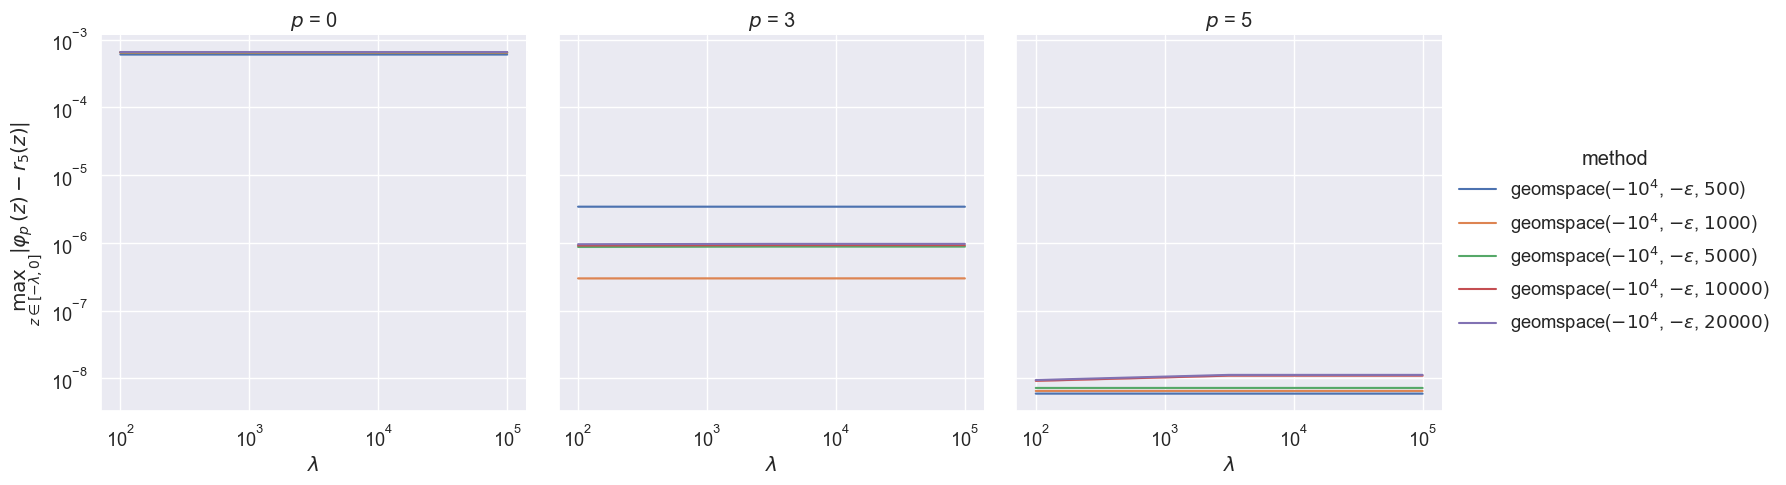

In [248]:
data = pd.DataFrame({'a': as_, 'p': ps, 'e': errors, 'method': methods})
df = data

fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='e',
    hue='method',
    col='$p$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
)
fg.set(xscale='log', yscale='log', ylabel='')

fg.axes[0, 0].set(ylabel=f'$\\max_{{z \\in [-\\lambda, 0]}} |\\varphi_p(z) - r_{{{m}}}(z)|$');

## What happens to the maximum error when m is increased?

In [71]:
ms = []
ps = []
as_ = []
errors = []

Z = np.geomspace(-1e04, -1e-16, int(30e03))

for m in [int(m) for m in [1, 4, 8, 12, 15, 20, 25, 30, 40]]:
    for p in tqdm([1, 3, 5], desc=f'm={m}'):
        f = Phi(p=p)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        for a in [1e03, 1e04, 1e05]:
            a = int(a)
            Z_err = np.linspace(-a, 0, (2 * a))
            ps.append(p)
            as_.append(a)
            ms.append(m)
            errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())


m=1:   0%|          | 0/3 [00:00<?, ?it/s]

m=4:   0%|          | 0/3 [00:00<?, ?it/s]

m=8:   0%|          | 0/3 [00:00<?, ?it/s]

m=12:   0%|          | 0/3 [00:00<?, ?it/s]

m=15:   0%|          | 0/3 [00:00<?, ?it/s]

m=20:   0%|          | 0/3 [00:00<?, ?it/s]

m=25:   0%|          | 0/3 [00:00<?, ?it/s]

m=30:   0%|          | 0/3 [00:00<?, ?it/s]

m=40:   0%|          | 0/3 [00:00<?, ?it/s]

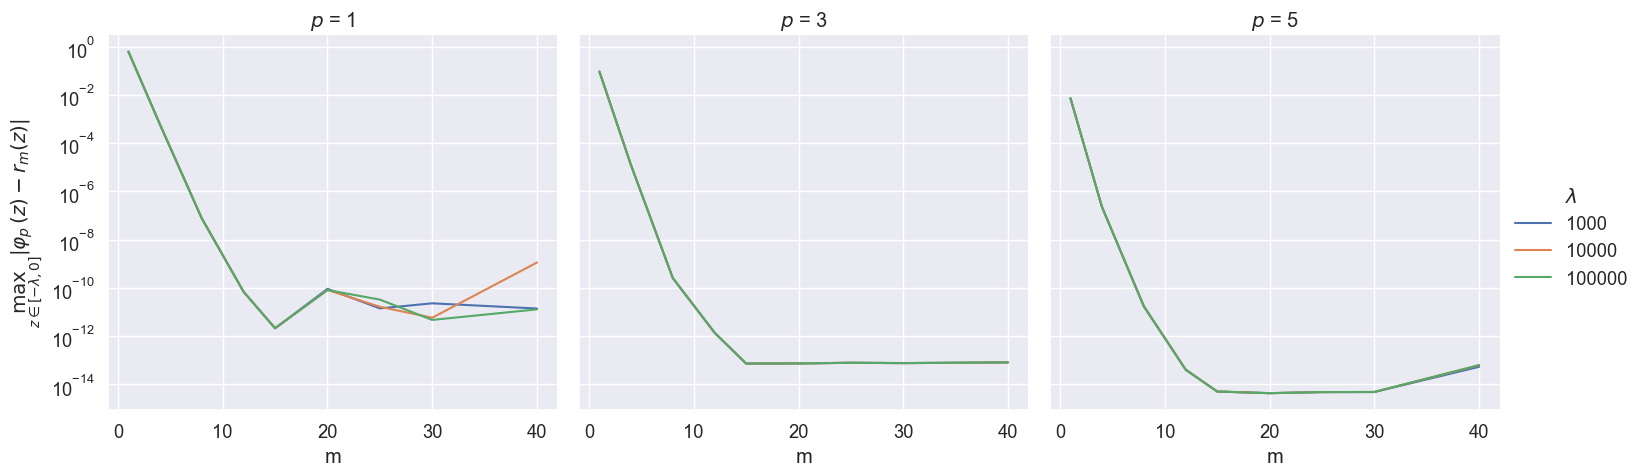

In [72]:
data = pd.DataFrame({'a': as_, 'p': ps, 'e': errors, 'm': ms})
df = data

fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='m',
    y='e',
    hue='$\\lambda$',
    col='$p$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
    # legend='brief',
    palette='deep',
)
fg.set(yscale='log', ylabel='')

fg.axes[0, 0].set(ylabel=f'$\\max_{{z \\in [-\\lambda, 0]}} |\\varphi_p(z) - r_m(z)|$');

## What happens to the poles when m is increased?

In [62]:
p = 3
f = Phi(p=p)

ms = [5, 10, 15, 20, 25, 30, 40, 50]
ns = [20e03, 30e03]

dfs = []
for n in ns:
    n = int(n)

    nodes, poles_real, poles_imag, errors = [], [], [], []
    for m in tqdm(ms):
        Z = np.linspace(-1e04, 0, n)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        errors.append(e)

    dfs_=[]
    for idx, m in enumerate(ms):
        dfs_.append(pd.DataFrame({'n': n, 'm': m, '$\\mathfrak{Re}(\\xi_k)$': poles_real[idx], '$\\mathfrak{Im}(\\xi_k)$': poles_imag[idx]}))
    dfs.append(pd.concat(dfs_))

df = pd.concat(dfs)

  0%|          | 0/3 [00:00<?, ?it/s]

[(-45.0, 10.0)]

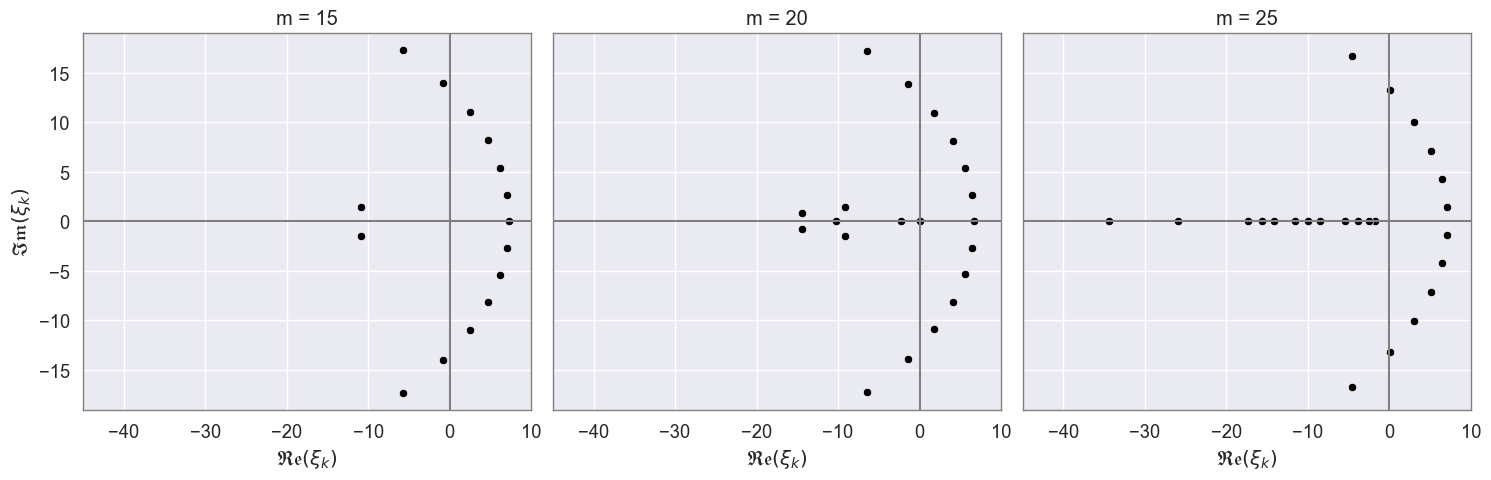

In [63]:
df_ = df

df_ = df_[
    (df['m'] == 15)
    | (df['m'] == 20)
    | (df['m'] == 25)
]

fg = sns.relplot(
    data=df_.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\mathfrak{Re}(\\xi_k)$',
    y='$\\mathfrak{Im}(\\xi_k)$',
    # hue='n',
    col='m',
    # col_wrap=4,
    kind='scatter',
    color='black',
    # palette='deep',
    facet_kws={'sharex': True, 'sharey': True, 'despine': False},
)

for ax in fg.axes.flatten():
    ax.axhline(y=0, color='gray', linestyle='-')
    ax.axvline(x=0, color='gray', linestyle='-')
    # ax.set(xlim=[-20, 10])
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)
fg.axes[0, -1].set(xlim=[-45, 10])

## Store the poles for different phi-functions

In [62]:
for p in tqdm([0, 1, 3, 5, 10]):
    # for m in [1, 3, 5, 10, 15, 20, 25, 30, 40]:
    for m in [2, 4, 6, 7, 8, 9]:
        f = Phi(p=p)

        n = int(30e03)
        Z = np.geomspace(-1e04, -1e-16, n)
        r = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=False)
        with open(f'data/poles/phi/p{p:02d}_m{m:03d}.npy', 'wb') as f:
            np.save(f, r.poles())

  0%|          | 0/5 [00:00<?, ?it/s]

# Experiments

In [39]:
mmax_PA = 600
mmax_RA = 100
ns = [n ** 2 for n in range(100, 0, -10)]
# ns = [int(n ** 2) for n in [100]]
as_ = [1e+03, 1e+04, 1e+05]
n_matrices = 2
ps = [0, 1, 3, 5]
nms = 50

In [ ]:
import warnings
warnings.filterwarnings('ignore')

dfs = []
# Get the error bounds
for a in as_:
    if False:
        d = get_bound_taylor(
            ps=ps, mmax=mmax_PA, nms=nms,
            alpha=a, vnorm=1,
        )
        d['name'] = 'Bound #1'
        d['a'] = a
        d['n'] = 0
        dfs.append(pd.DataFrame(d))

    if False:
        d = get_bound_chebyshev(
            ps=ps, mmax=mmax_PA, nms=nms,
            alpha=a, vnorm=1,
        )
        d['name'] = 'Bound #2'
        d['a'] = a
        d['n'] = 0
        dfs.append(pd.DataFrame(d))

# Get approximation convergences
pbar_n = tqdm(total=len(ns), desc='Sizes (n)', leave=True)
for n in ns:
    pbar_n.desc = f'Sizes (n={n})'
    pbar_n.refresh()

    # Get random vector v and normalize it
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)

    # Set the name of the test matrices
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']

    # Get the eigenvalues of A1 and A2
    eigs = {}
    A1 = get_FD_matrix(n=n, d=1, scale=False)
    eigs['A1'] = (
        sps.linalg.eigsh(A1, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A1, k=1, which='LA', return_eigenvectors=False).item(),
    )
    A2 = get_FD_matrix(n=(n ** .5), d=2, scale=False)
    eigs['A2'] = (
        sps.linalg.eigsh(A2, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A2, k=1, which='LA', return_eigenvectors=False).item(),
    )

    pbar_a = tqdm(total=len(as_), desc='Eigenvalues (a)', leave=False)
    for a in as_:
        pbar_a.desc = f'Eigenvalues (a={a:.0e})'
        pbar_a.refresh()

        matrices = get_test_matrices(n=n, interval=(-a, 0), eigs=eigs)

        # Get convergence data for the test matrices
        pbar_A = tqdm(total=n_matrices, desc='Matrices (A)', leave=False)
        for name, A in zip(names[:n_matrices], matrices[:n_matrices]):
            pbar_A.desc = f'Matrices (A={name})'
            pbar_A.refresh()

            pbar_p = tqdm(total=len(ps), desc='Phi-function (p)', leave=False)
            for p in ps:
                pbar_p.desc = f'Phi-function (p={p})'
                pbar_p.refresh()
                d = get_convergence_phi(
                    funcs=[Phi(p=p)],
                    A=A,
                    v=v,
                    ks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
                    mmax_PA=min(n - 20, mmax_PA),
                    mmax_RA=min(n - 20, mmax_RA),
                    nms=nms,
                )
                d['name'] = [name] * len(d['err'])
                d['n'] = [n] * len(d['err'])
                d['a'] = [a] * len(d['err'])
                d['p'] = [p] * len(d['err'])
                dfs.append(pd.DataFrame(d))
                pbar_p.update()


            pbar_p.close()
            pbar_A.update()

        pbar_A.close()
        pbar_a.update()

    pbar_a.close()
    pbar_n.update()

pbar_n.close()


# Build the dataframe and save it
df = pd.concat(dfs)
df.to_csv('tmp.csv', index=False)

warnings.filterwarnings('default')
print('Done!')

## Store/load of the results

In [8]:
# Save the experiments
df.to_csv('phifuncs.csv', index=False)

In [3]:
# Load the experiments
df = pd.read_csv('tmp.csv')

# Plots

## Convergence for different $\varphi$-functions

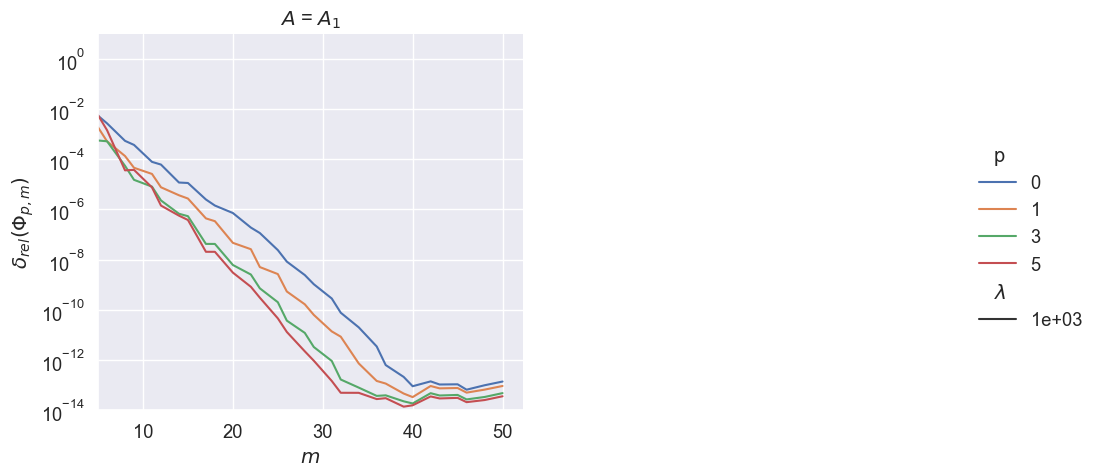

In [8]:
data = df[
    ((df['method'] == 'RA-ONES'))
    & ((df['name'] != 'bound'))
    & (df['n'] == 10000)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);

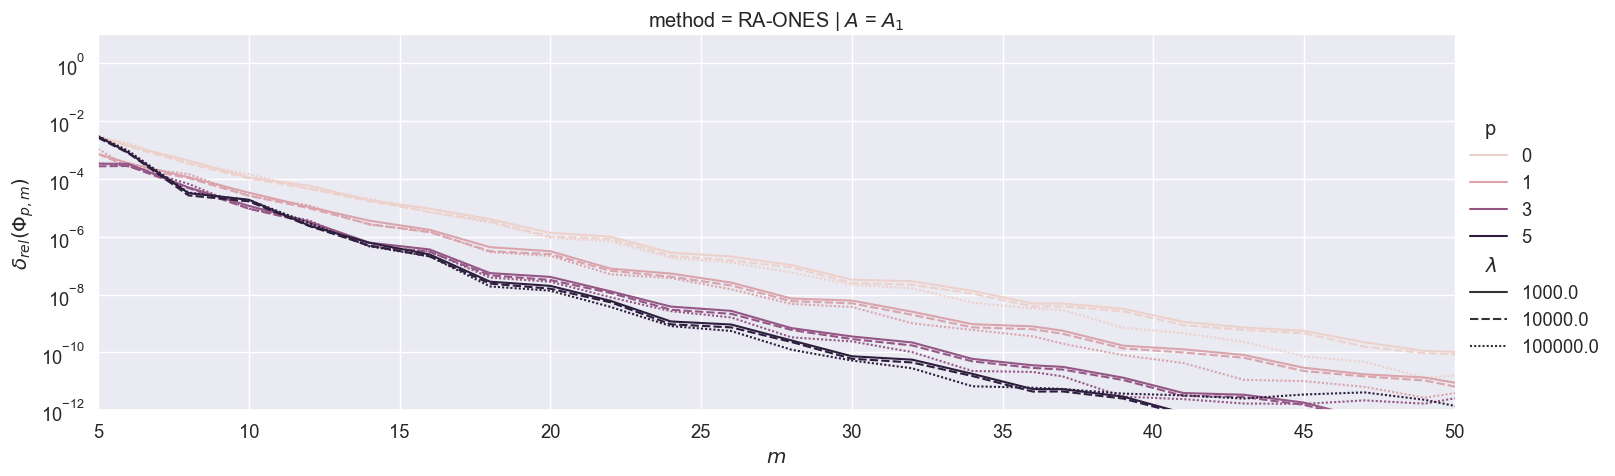

In [38]:
data = df[
    # phi functions
    (df['p'] != 10)

    # Method
    & ((df['method'] == 'RA-ONES'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == 10000) | (df['a'] == 5000) | (df['a'] == 1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    # & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    row='method',
    style='$\\lambda$',
    # col_wrap=2,
    facet_kws={'sharex': False},
    height=5,
    aspect=3,
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);
fg.axes[0, 0].set(xlim=[5, 50]);

## Error bounds

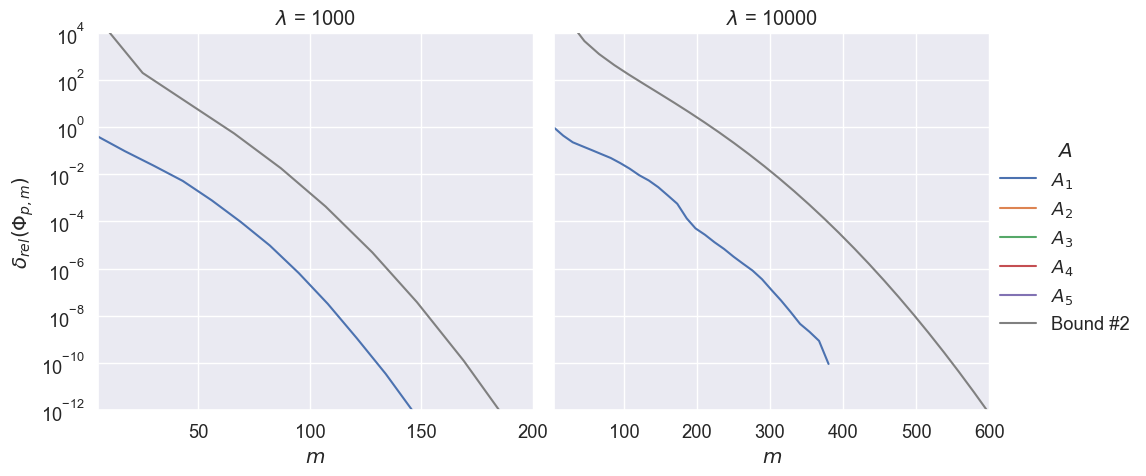

In [41]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Size
    & ((df['n'] == 10000) | (df['n'] == 0))

    # Smallest eigenvalue
    & ((df['a'] == 1e03) | (df['a'] == 1e04))
]
data = data.reset_index()

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'Bound #2'],
    col_order=[1000, 10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'gray'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+04],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different pole selection strategies

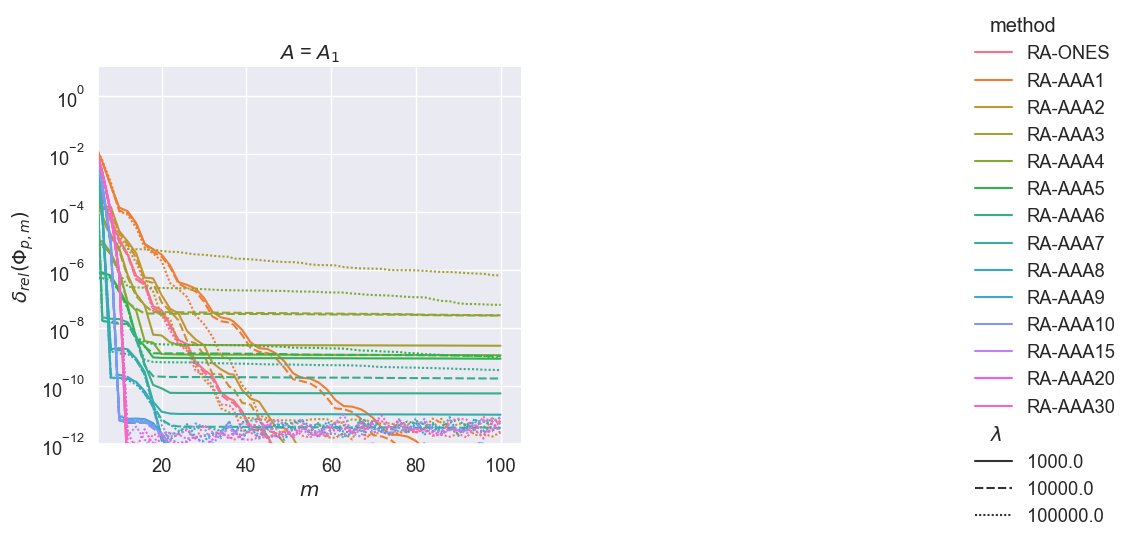

In [16]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] != 'EX') & (df['method'] != 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == 100000) | (df['a'] == 10000) | (df['a'] == 1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    style='$\\lambda$',
    col='$A$',
    hue='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
)
# fg.axes[0].set(xlim=[5, 60])
# fg.axes[1].set(xlim=[5, 30])
# fg.axes[2].set(xlim=[5, 40])
# fg.axes[3].set(xlim=[5, 60])
# fg.axes[4].set(xlim=[5, 20])

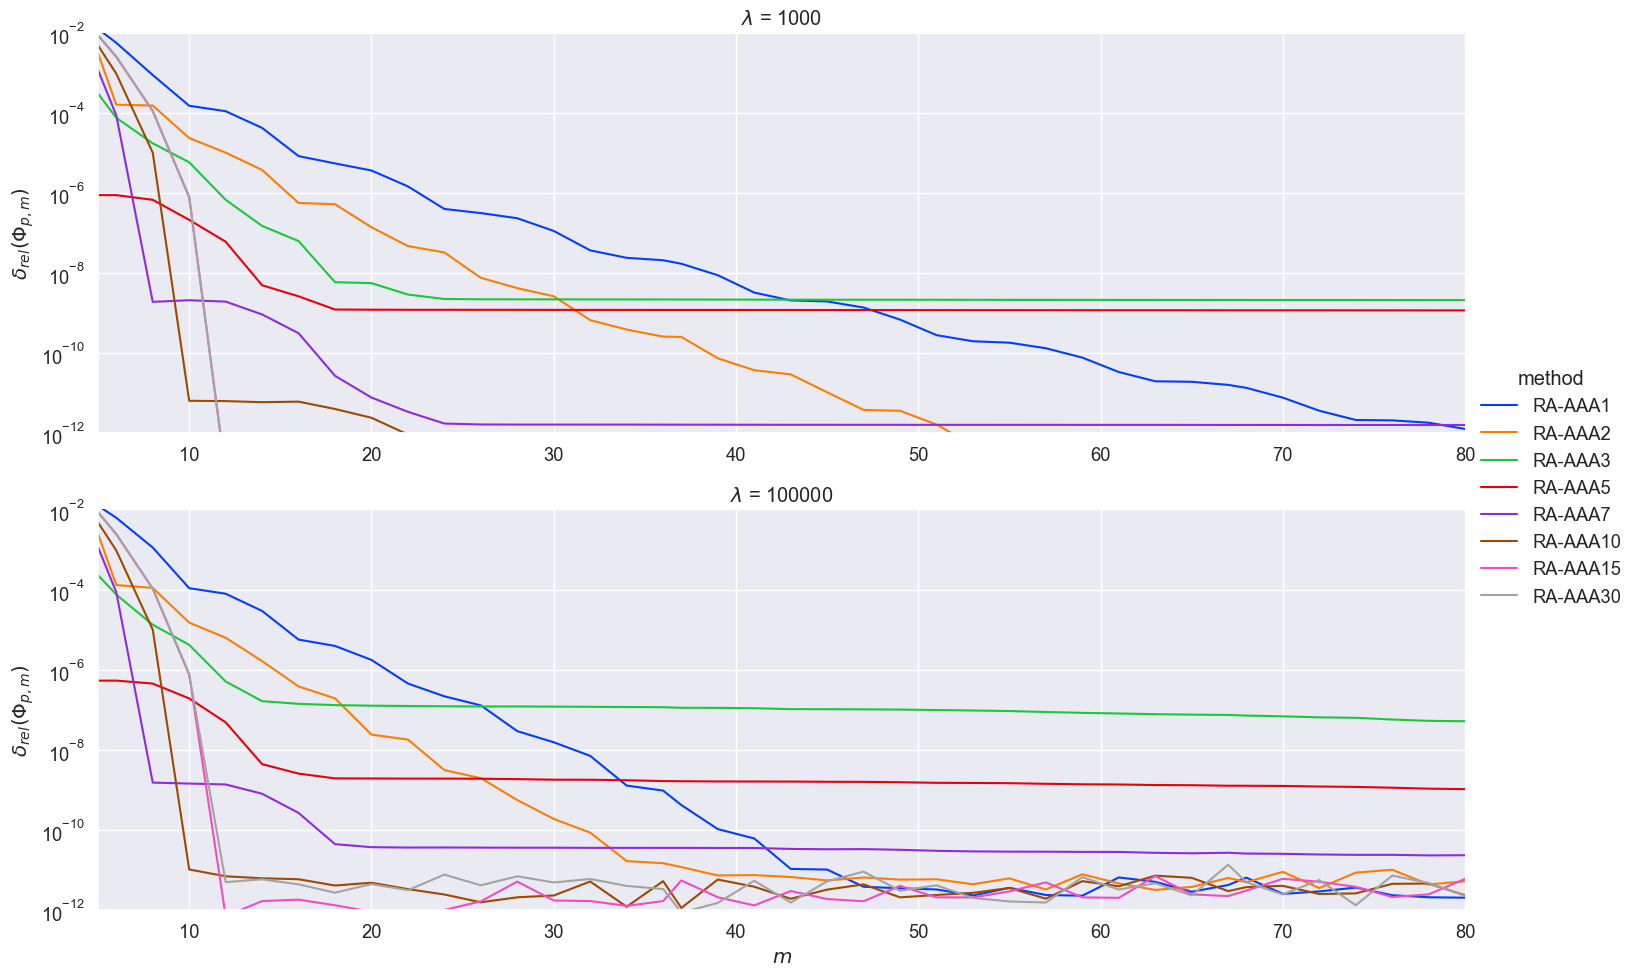

In [6]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    # & (((df['method'].str.contains('AAA'))) | (df['method'] == 'RA-ONES'))
    & (
        (df['method'] == 'RA-AAA1')
        # (df['method'] == 'RA-ONES')
        | (df['method'] == 'RA-AAA2')
        | (df['method'] == 'RA-AAA3')
        | (df['method'] == 'RA-AAA5')
        | (df['method'] == 'RA-AAA7')
        | (df['method'] == 'RA-AAA10')
        | (df['method'] == 'RA-AAA15')
        | (df['method'] == 'RA-AAA30')
    )

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    & ((df['a'] == 100000) | (df['a'] == 1000))
].copy()

data['a'] = data['a'].astype(int)
fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    row='$\\lambda$',
    # col='$A$',
    hue='method',
    # col_wrap=2,
    palette='bright',
    height=5,
    aspect=3,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, 80],
    ylim=[1e-12, 1e-02],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
)

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

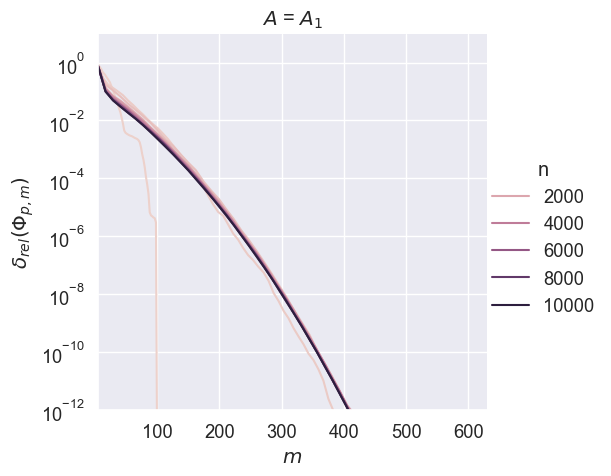

In [130]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == 10000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='n',
    # col='method',
    row='$A$',
    # col_wrap=2,
    # facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## CPU time with different n

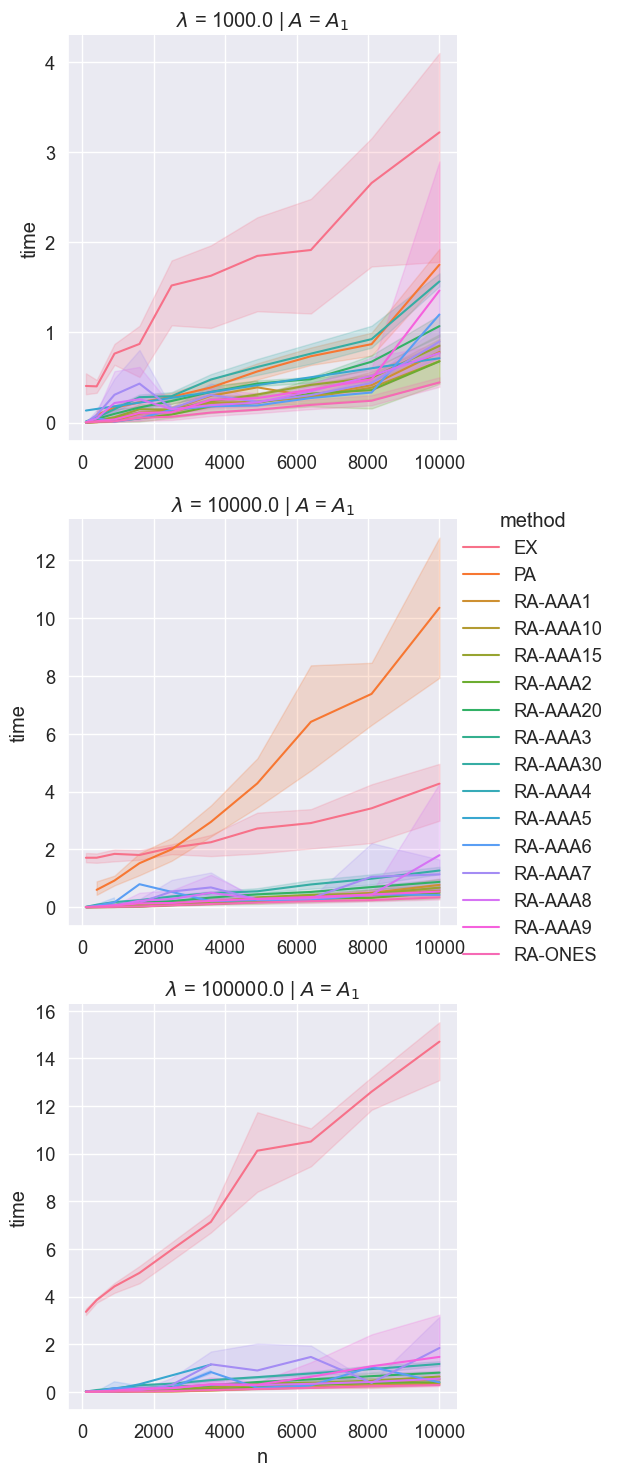

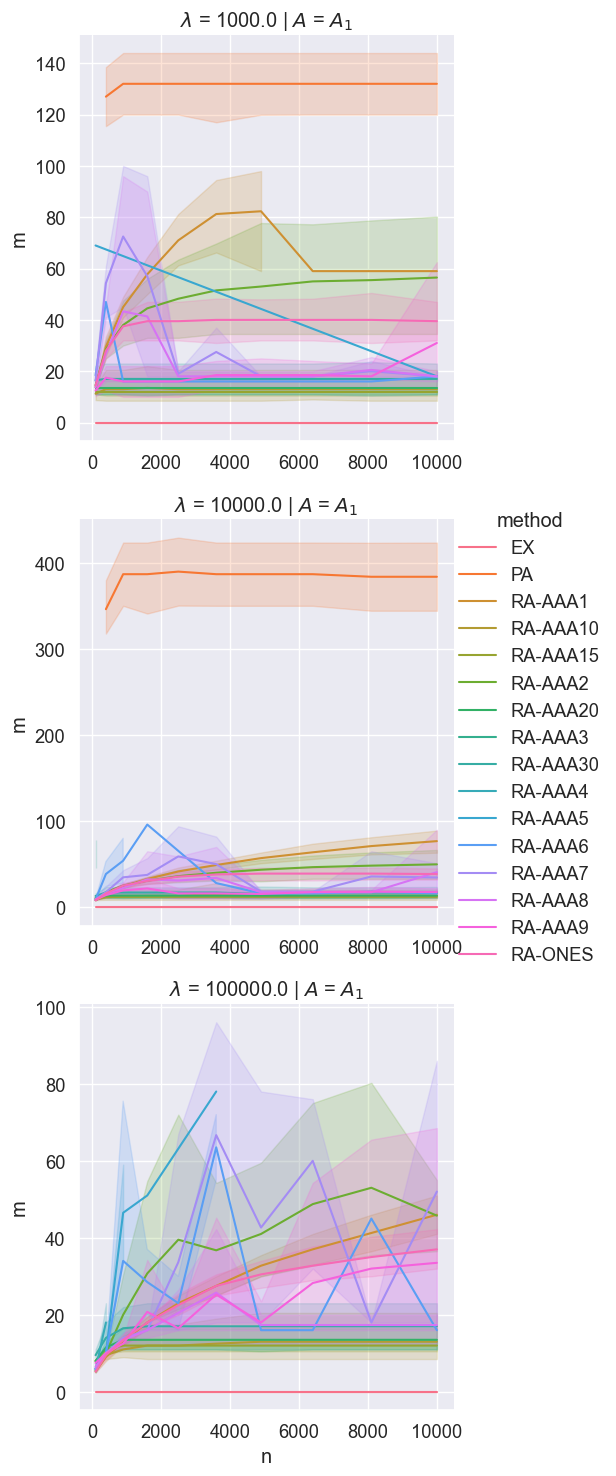

In [18]:
data = df[
    ((df['name'] != 'bound'))
    # & ((df['p'] == 5))
    # & ((df['method'].str.contains('RA')))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)

# Plot CPU time
fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

# Plot smallest m
fg = sns.relplot(
    data=data,
    x='n',
    y='m',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

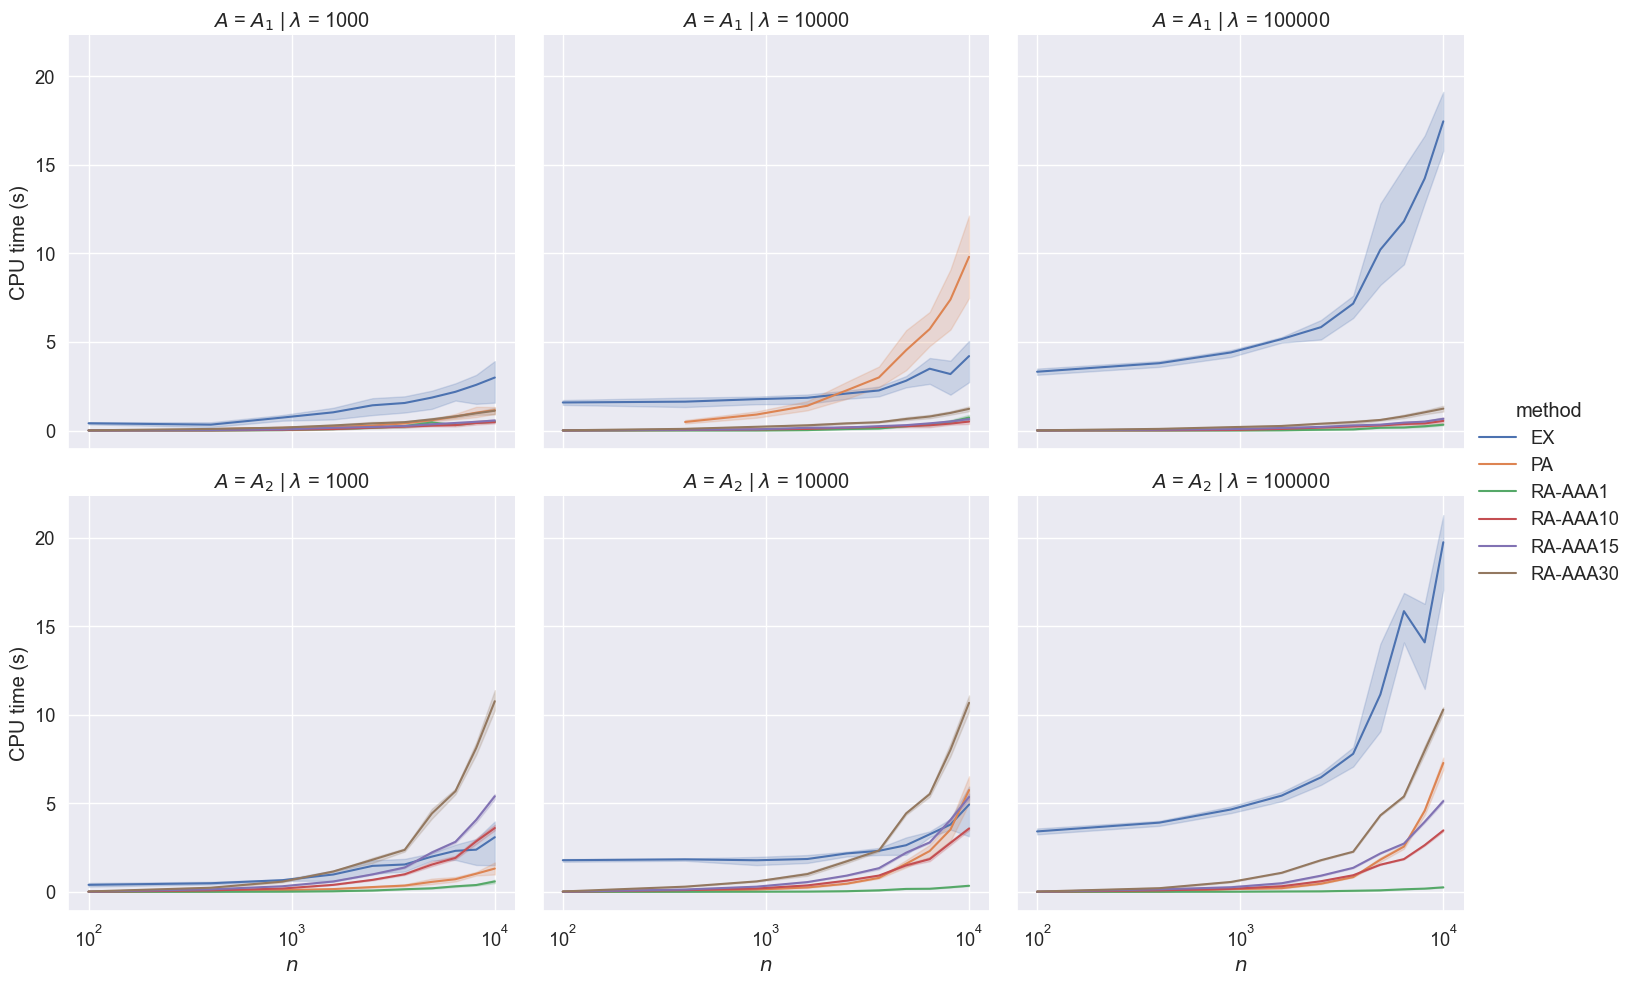

In [7]:
data = df[
    ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))
    & (
    (df['method'] == 'RA-AAA1')
    | (df['method'] == 'EX')
    | (df['method'] == 'PA')
    | (df['method'] == 'RA-AAA10')
    | (df['method'] == 'RA-AAA15')
    | (df['method'] == 'RA-AAA30')
    )
    # & ~((df['a'] == 100000) & (df['method'] == 'PA') & (df['name'] == '$A_1$'))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)


fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    row='$A$',
    col='$\\lambda$',
    col_order=[1000, 10000, 100000],
    # facet_kws={'sharey': False}
)
fg.set(
    xscale='log',
    ylabel='CPU time (s)',
    xlabel='$n$',
)